# Simple pendulum system

Consider a simple pendulum of length $l$ and mass $m$ concentrated at its bob. The pivot of the pendulum is attached to a fix point. The system is submitted to a uniform, constant gravitational acceleration field $g$ and moves without friction.

The generalised coordinate of the system is the angle $\theta$ of the pendulum with the downward vertical direction. The standard (Cartesian) coordinates of the bob are then given by

\begin{equation*}
x = l\sin\theta
\hspace{2cm}
y = -l\cos\theta
\end{equation*}

The only active force is weight with coordinates $(0,-mg)$, hence of the form $-\nabla V$ with $V=mgy=-mgl\cos\theta$. Hence the Lagrangian

\begin{eqnarray*}
\mathcal{L} & = & ml(\frac{1}{2}l\dot{\theta}^2+g\cos\theta)
\end{eqnarray*}

The equations of the dynamics are given by:

\begin{equation*}
\begin{array}{rrcl}
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{\theta}} = \frac{\partial\mathcal{L}}{\partial\theta}\right]
\hspace{1cm} &
l\ddot{\theta} & = & -g\sin\theta
\end{array}
\end{equation*}

Documentation: [here](../doc/_build/html/odesimu.html)

In [2]:
%pylab nbagg
# for better display performance, use default backend

import logging
logger = logging.getLogger()

from functools import partial
from scipy.integrate import quad
from ipyshow.odesimu.system import System
from ipyshow.odesimu.util import logger_hook

Populating the interactive namespace from numpy and matplotlib


## Pendulum class

In [3]:
#----------------------------------------------------------------------------------------------------
class Pendulum (System):
#----------------------------------------------------------------------------------------------------

    shadowshape = (2,)

    def __init__(self,L,G):
        """
:param G: gravitational acceleration, in m/s^2
:param L: length of pendulum in m
        """
        self.L, self.G = L, G
        def main(t,state,a=-G/L):
            theta,dtheta = state
            ddtheta = a*sin(theta)
            return array((dtheta, ddtheta))
        self.main = main
        def jac(t,state,a=-G/L):
            theta,dtheta = state
            return array(((0,1),(a*cos(theta),0)))
        self.jacobian = jac
        def analytics(state,a=-G/L):
            theta,dtheta = state
            K = square(dtheta)+2*a*cos(theta)
            return K
        self.analytics = analytics
        def fordisplay(state):
            theta,w = state
            live = L*sin(theta), -L*cos(theta)
            return live, live
        self.fordisplay = fordisplay

    def display(self,ax,ini=None,refsize=50.,**ka):
        """
:param refsize: size in points^2 of the pendulum (and rotation axe)
        """
        L = 1.05*self.L
        ax.set_xlim(-L,L)
        ax.set_ylim(-L,L)
        ax.scatter((0.,),(0.,),c='k',marker='o',s=refsize)
        diag_l, = ax.plot((),(),'k')
        diag_s = ax.scatter((),(),s=refsize,marker='o',c='r')
        tail_l, = ax.plot((),(),'y')
        a = -self.G/self.L
        K = self.analytics(ini)
        c = .5*K/a
        if c<-1: q = 1; alpha = pi
        elif c==-1: q = nan; alpha = pi
        else: q = 2; alpha = arccos(c)
        if alpha<.1: T = pi/sqrt(2)
        else: T, err = quad((lambda t,c=c: 1/sqrt(cos(t)-c)),0,alpha)
        T *= q*sqrt(-2/a)
        ax.set_title(r'trajectory:CircularSegment($R$={:.2f},$\alpha$={:.2f}) period:{:.2f}'.format(self.L,alpha*180/pi,T))
        def disp(t,live,tail):
            x,y = live
            diag_l.set_data((0,x),(0,y))
            diag_s.set_offsets(((x,y),))
            tail_l.set_data(tail[:,0],tail[:,1])
        return super(Pendulum,self).display(ax,disp,ini=ini,**ka)

    @staticmethod
    def makestate(theta=0.,w=0.): return array((theta,w),float)*pi/180.

    launchdefaults = dict(
        maxtime=infty,
        srate=25.,
        taild=1,
        hooks=(partial(logger_hook,logger=logger),),
        animate=dict(repeat=False,),
    )

Launcher
--------

System parameters:

* `L`: length of pendulum (in m)
* `G`: gravitational acceleration (in m.sec$^{-2}$)

Launch parameters:

* `ini/theta`: initial angle of pendulum with downward vertical (in deg)
* `ini/w`: initial angular speed (in deg.sec$^{-1}$)
* `srate`: simulation rate (in frames.sec$^{-1}$)
* `taild`: duration of shadow, ie. trace of previous states (in sec)
* `hooks`: list of display hooks (see doc)

<IPython.core.display.Javascript object>


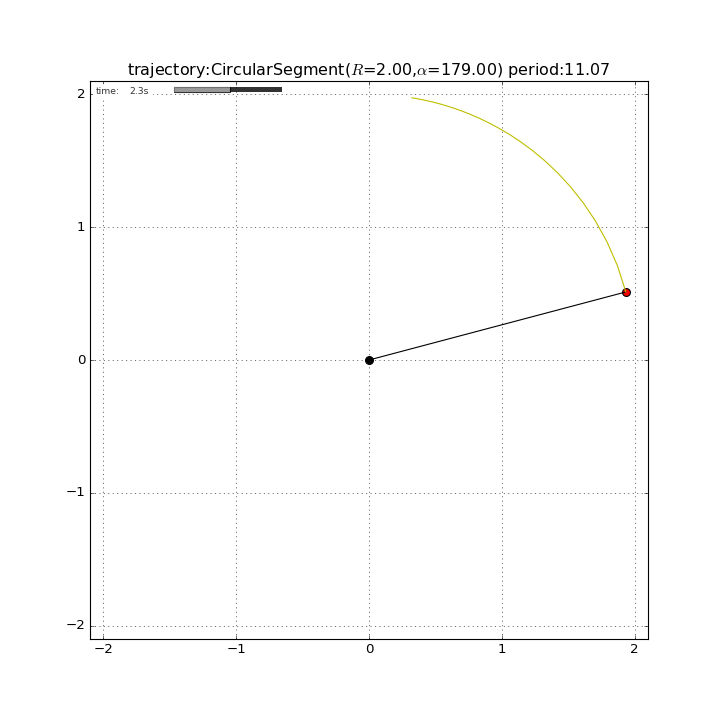

In [4]:
logger.setLevel(logging.WARN) # can be changed dynamically by logger_hook
syst = Pendulum(L=2.,G=9.81,); ini = dict(theta=179.,w=0.)
syst.launch(ini=syst.makestate(**ini))

Trajectory
----------

The law of conservation of energy yields $\dot{\theta}^2=K+\frac{2g}{l}\cos\theta$ for some constant $K$ (total energy). Let $c=-\frac{Kl}{2g}$.

* If $c\lt-1$ then the trajectory is the whole circle ($\alpha=\pi$) and the motion is periodic;

* if $c=-1$ the trajectory is a circle segment ending at the top-most point of the circle, where the motion stops;

* if $-1\lt c\lt1$ the trajectory is a circle segment limited by the angles $-\alpha$ and $\alpha$ where $\cos\alpha=c$ and the motion is periodic;

* if $c=1$, the trajectory is the bottom-most point of the circle and the motion is null;

* by construction, it is impossible that $c\gt1$.

The initial condition defines the value of $K$.

Periodicity
-----------

When $|c|\not=1$, the motion is periodic and the period is given by

\begin{equation*}
T = k\sqrt{\frac{2l}{g}}\int_0^\alpha\frac{\mathbf{d}\theta}{\sqrt{\cos\theta-c}}
\textrm{ where } k=1 \textrm{ if } c\lt-1 \textrm{ and } k=2 \textrm{ if } -1\lt c\lt 1
\end{equation*}

Now, when $c\geq0$, we have $c=\cos\alpha$ and $k=2$. Using the change of variable $t=\frac{\theta}{\alpha}$ we get

\begin{equation*}
T=2\sqrt{\frac{2l}{g}}I(\alpha)
\hspace{1cm}\textrm{where}\hspace{1cm}
I(\alpha)=\int_0^\alpha\frac{\mathbf{d}\theta}{\sqrt{\cos\theta-\cos\alpha}}=
\int_0^1\frac{\alpha\mathbf{d}t}{\sqrt{\cos t\alpha-\cos\alpha}}
\end{equation*}

When $c$ tends to $1$, then $\alpha$ tends to $0$ and the integrand monotonously converges pointwise to $f(t)=\sqrt{\frac{2}{1-t^2}}$. Hence, by the [monotone convergence theorem](http://en.wikipedia.org/wiki/Monotone_convergence_theorem), and using the change of variable $t=\sin u$ we get

\begin{equation*}
\lim_{\alpha\downarrow0}I(\alpha) = \int_0^1\frac{\sqrt{2}\mathbf{d}t}{\sqrt{1-t^2}} =
\int_0^{\frac{\pi}{2}}\frac{\sqrt{2}\cos u\mathbf{d}u}{\sqrt{1-\sin^2u}} = \frac{\pi}{\sqrt{2}}
\hspace{1cm}\textrm{hence}\hspace{1cm}
\lim_{c\downarrow1}T = 2\pi\sqrt{\frac{l}{g}}
\end{equation*}